<a href="https://colab.research.google.com/github/gandharvbakshi/AI-and-ML-Hackathons/blob/main/Sound%20Generation%20trials%20using%20FFT%20and%20CNN%20Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import sys
import librosa
import librosa.display
import os

In [2]:
!pip3 install pytube
!pip install ffmpeg
!pip3 install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=32318fb32ac2c731f8b3c705a973460799c4aed42b15759897cfbbb008759f65
  Stored in directory: /root/.cache/pip/wheels/64/80/6e/caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
Successfully built ffmpeg
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
images_dir = "/content/drive/MyDrive/AI ML Projects/Music/Guitar Files Images"
music_array_dir = "/content/drive/MyDrive/AI ML Projects/Music/Guitar Music Arrays"
normalized_music_array_dir = "/content/drive/MyDrive/AI ML Projects/Music/Guitar Music Normalized Arrays/"

In [4]:
max_value = np.load(normalized_music_array_dir + "/" + "max_value.npy")[0]
print(max_value)

144.75938838435175


In [5]:
fs = 44100
latent_dim = int(fs * 5)
spect_img_shape = (1025, 431)
chunk_size = latent_dim

In [ ]:
from scipy.io import wavfile
fs, data = wavfile.read('/content/drive/MyDrive/AI ML Projects/Music/Guitar_music_romantic_top_30.wav')            # reading the file

#wavfile.write('guitar_channel_1.wav', fs, data[:, 0])   # saving first column which corresponds to channel 1
#wavfile.write('guitar_channel_2.wav', fs, data[:, 1]) 

In [ ]:
data.shape, fs
data[:, 0][0:fs*15].shape

(661500,)

In [ ]:
from IPython.display import Audio
Audio(data[:, 0][0:fs*15], rate=fs)

In [ ]:
from PIL import Image

#prep_train_data
latent_dim = int(fs * 5)
spect_img_shape = (1025, 431)
chunk_size = latent_dim

def audio_spect_image_files(data, fs):
  max_data_value = 0
  num_train_data = int( data[:, 0].shape[0] / (chunk_size))
  x_train = [] 
  print(data[:, 0].shape)
  for i in range(0, int(num_train_data)):
    #x_train.append(data[:, 0][(i * chunk_size): ( (i+1) * chunk_size)])
    temp_array = get_histogram_from_array_sr(data[:, 0][(i * chunk_size): ( (i+1) * chunk_size)].astype(np.float), fs)
    np.save(music_array_dir + "/" + str(i) + ".npy", temp_array)
    #im = Image.fromarray(temp_array.astype(np.uint8))
    #im.save(images_dir + "/" + str(i) + ".jpeg")
    #if i%(500) == 0:
    #  plt.imshow(im)
    #  plt.show()
  #x_train = np.array(x_train)
  #max_data_value = x_train.max()
  #x_train = (x_train/ (max_data_value / 2)) - 1.0 #x_train/x_train.max()
  #print(x_train.shape, x_train.max(), x_train.min())

audio_spect_image_files(data, fs)

(489244672,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


In [6]:
# import libraries and modules
%matplotlib inline

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# import pytorch related modules
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize, RandomCrop, Normalize

from torch.optim import Adam

from torch.nn import Sequential
from torch.nn import Linear, LeakyReLU, BatchNorm2d, Sigmoid, Tanh, Flatten, BCELoss, Conv2d, ConvTranspose2d, ReLU, ZeroPad2d

from torch.nn.init import normal_, constant_

In [7]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [8]:
def plot_spectrogram(Y, sr, hop_length, y_axis="log"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                            sr=sr, 
                            hop_length=hop_length, 
                            x_axis="time", 
                            y_axis=y_axis)
    plt.colorbar(format="%+2.f")

def plot_spectrogram_from_log_array_sr(Y_log_scale, sr):
  HOP_SIZE = 512  
  plot_spectrogram(Y_log_scale, sr, HOP_SIZE, y_axis="log")

def plot_spectrogram_from_array_sr(scale, sr, FRAME_SIZE = 2048, HOP_SIZE = 512):
  #scale, sr = librosa.load(fileName)
  FRAME_SIZE = 2048
  HOP_SIZE = 512    
  S_scale = librosa.stft(scale, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
  #print(S_scale.shape, type(S_scale[0][0]))
  Y_scale = (S_scale) ** 2 #np.abs
  #print(Y_scale.shape, Y_scale.max(), Y_scale.min())
  Y_log_scale = librosa.power_to_db(Y_scale)
  print(Y_log_scale.shape, Y_log_scale.max(), Y_log_scale.min())
  plot_spectrogram(Y_log_scale, sr, HOP_SIZE, y_axis="log")

def get_histogram_from_array_sr(scale, sr):
  FRAME_SIZE = 2048
  HOP_SIZE = 512    
  S_scale = librosa.stft(scale, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
  #print(S_scale.shape, type(S_scale[0][0]))
  Y_scale = (S_scale) ** 2 #np.abs
  #print(Y_scale.shape, Y_scale.max(), Y_scale.min())
  Y_log_scale = librosa.power_to_db(Y_scale)
  return Y_log_scale

FRAME_SIZE = 2048
HOP_SIZE = 512    

def reverse_log_ftf(Y_log_scale, hop_length=HOP_SIZE ):
  Y_scale_reversed = librosa.db_to_power(Y_log_scale)
  S_scale_reversed = np.sqrt(Y_scale_reversed)
  scale_reversed = librosa.istft(S_scale_reversed, hop_length=HOP_SIZE)
  return scale_reversed

In [9]:
# define custom dataset class
class GuitarSpectDataset(Dataset):
    def __init__(self, normalized_music_array_dir):
        # get image names of images which are chequered
        #print("start of init")
        self.file_names = os.listdir(normalized_music_array_dir)
        self.file_names = [f for f in self.file_names if f!="max_value.npy"]
        print(len(self.file_names))
        #self.max_value = 0

        # get image paths
        self.file_paths = []
        for file_name in self.file_names:
            self.file_paths.append(os.path.join(normalized_music_array_dir, file_name))
            #curr_array = np.load(os.path.join(music_array_dir, file_name))
            #if self.max_value < curr_array.max():
            #  self.max_value = curr_array.max()
        #print("end of init")
    
    def __getitem__(self, idx):
        #print("getting item")
        # read data
        #image = Image.open(self.images_paths[idx])
        curr_array = np.load(self.file_paths[idx])

        # apply data augmentation
        transform = Compose([
                    #Grayscale(),
                    #Resize(80),
                    #RandomCrop(64),
                    ToTensor(),
                    #Normalize([0.5], [0.5])
                    ])
        
        #image = transform(image)
        transformed_array = transform(curr_array)
        #if self.max_value > 0:
        #  transformed_array = (transformed_array / (self.max_value / 2)) - 1.0
        #print("done with getting item")
        return transformed_array
        
    def __len__(self):
        return len(self.file_names)

In [10]:
# create instance of custom dataset
dataset = GuitarSpectDataset(normalized_music_array_dir)

# create dataloader
data_loader = DataLoader(
    dataset, 
    batch_size=16,
    num_workers=4,
    shuffle=True
)

9869


In [ ]:
%%time

# check for one iteration of loop
#i = 0
for batch_x in data_loader:
    #print(i)
    #i = i + 1
    break

CPU times: user 76.6 ms, sys: 51 ms, total: 128 ms
Wall time: 14.2 s


In [ ]:
import time
epochs = 10
for epoch in range (0, epochs):
  start = time.time()
  for i, batch_x in enumerate(data_loader):
    pass 
  end = time.time()
  print("epoch = ", epoch, "time = ", end - start)

epoch =  0 time =  1212.4529087543488
epoch =  1 time =  1247.1529200077057
epoch =  2 time =  1177.8108956813812
epoch =  3 time =  1180.1229112148285
epoch =  4 time =  1182.6545231342316
epoch =  5 time =  1195.8447842597961
epoch =  6 time =  1197.4536724090576
epoch =  7 time =  1187.6522855758667
epoch =  8 time =  1182.476277589798
epoch =  9 time =  1198.183798789978


In [ ]:
# get shapes of batches
batch_x.shape

torch.Size([16, 1, 1025, 431])

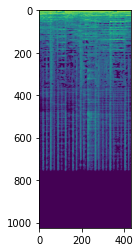

In [ ]:
# print image
plt.imshow(batch_x[1].squeeze())

In [ ]:
batch_x.min(), batch_x.max()

(tensor(-0.4130, dtype=torch.float64), tensor(0.9424, dtype=torch.float64))

In [11]:
# define discriminator model architecture

# Input
# Dense(num_neurons=128, activation='leaky_relu')
# Dense(num_neurons=64, activation='leaky_relu')
# Dense(num_neurons=1, activation='sigmoid')

'''discriminator = Sequential(
    Linear(1025*431*1, 512),
    LeakyReLU(0.2),
    Linear(512, 128),
    LeakyReLU(0.2),
    Linear(128, 64),
    LeakyReLU(0.2),
    Linear(64, 1),
    Sigmoid()
)'''

discriminator = Sequential(
    Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=4, padding=1, bias=False),
    LeakyReLU(0.2),
    Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=4, padding=1, bias=False),
    BatchNorm2d(32),
    LeakyReLU(0.2),
    Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=4, padding=1, bias=False),
    BatchNorm2d(64),
    LeakyReLU(0.2),
    Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(128),
    LeakyReLU(0.2),
    Conv2d(in_channels=128, out_channels=2, kernel_size=3, stride=3, padding=0, bias=False),
    BatchNorm2d(2),
    LeakyReLU(0.2),
    Conv2d(in_channels=2, out_channels=1, kernel_size=1, stride=2, padding=0, bias=False),
    Sigmoid()
)

In [12]:
discriminator 

Sequential(
  (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1), bias=False)
  (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1), bias=False)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2)
  (11): Conv2d(128, 2, kernel_size=(3, 3), stride=(3, 3), bias=False)
  (12): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): LeakyReLU(negative_slope=0.2)
  (14): Conv2d(2, 1, kernel_size=(1, 1), s

In [ ]:
# check model on one image
output = discriminator(batch_x[:1].float()).detach().numpy()

In [ ]:
output

array([[[[0.45399505]]]], dtype=float32)

In [13]:
# define generator model architecture

# Input
# Dense(num_neurons=64, activation='leaky_relu')
# Dense(num_neurons=128, activation='leaky_relu')
# Dense(num_neurons=64*64, activation='tanh')

"""generator = Sequential(
    Linear(100, 64),
    LeakyReLU(0.2),
    Linear(64, 128),
    BatchNorm1d(128),
    LeakyReLU(0.2),
    Linear(128, 512),
    BatchNorm1d(512),
    LeakyReLU(0.2),
    Linear(512, 1025*431*1),
    Tanh()
)"""

generator = Sequential(
    ConvTranspose2d(in_channels=1, out_channels=64, kernel_size=2, stride=4, padding=2, bias=False),
    BatchNorm2d(64),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=4, padding=2, bias=False),
    BatchNorm2d(32),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=4, padding=2, bias=False),
    ZeroPad2d((0,-19,0,-1)),
    Tanh()
)

In [14]:
generator

Sequential(
  (0): ConvTranspose2d(1, 64, kernel_size=(2, 2), stride=(4, 4), padding=(2, 2), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(4, 4), padding=(2, 2), bias=False)
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(4, 4), padding=(2, 2), bias=False)
  (7): ZeroPad2d((0, -19, 0, -1))
  (8): Tanh()
)

In [ ]:
# check model on one image
generator.eval()
output = generator(torch.randn(1, 1, 18, 9)).detach().numpy()

In [ ]:
output.shape

(1, 1, 1025, 431)

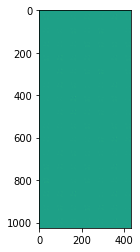

In [ ]:
plt.imshow(((output.reshape(1025, 431) + 1)/2) * max_value)

In [15]:
discriminator = discriminator.to('cuda')
generator = generator.to('cuda')

In [16]:
# Initialize BCELoss function
criterion = BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# fixed noise for plotting
fixed_noise = torch.randn(1, 1, 18, 9)

# number of epochs
num_epochs = 100

# Setup Adam optimizers for both G and D
optimizerD = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [17]:
num_epochs=100

In [18]:
default_save_path = "/content/drive/MyDrive/AI ML Projects/Music/checkpoints"

def save_checkpoint(gen, opt_gen, disc, opt_disc, epoch, save_path = default_save_path):
  checkpoint = {
    "gen_state": gen.state_dict(),
    "gen_optimizer": opt_gen.state_dict(),
    "disc_state": disc.state_dict(),
    "disc_optimizer": opt_disc.state_dict()
}
  torch.save(checkpoint, os.path.join(save_path, "checkpoint_" + str(epoch) + ".pt" ) )

#    torch.save({
#        'model_state_dict': model.state_dict(),
#        'optimizer_state_dict': optimizer.state_dict(),
#        'epoch': epoch
#    }, save_path)

def load_checkpoint(gen, opt_gen, disc, opt_disc, epoch, load_path = default_save_path):
    checkpoint = torch.load(load_path)
    gen.load_state_dict(checkpoint['gen_state'])
    opt_gen.load_state_dict(checkpoint['gen_optimizer'])
    disc.load_state_dict(checkpoint['disc_state'])
    opt_disc.load_state_dict(checkpoint['disc_optimizer'])
#    epoch = checkpoint['epoch']
    
    return gen, opt_gen, disc, opt_disc, epoch

In [19]:
curr_epoch = -1

# set model to train
discriminator.train()
generator.train()

generator, optimizerG, discriminator, optimizerD, curr_epoch = load_checkpoint(generator, optimizerG, discriminator, optimizerD, 52, '/content/drive/MyDrive/AI ML Projects/Music/checkpoints/checkpoint_52.pt')

In [20]:
# train model
for epoch in range(curr_epoch + 1, num_epochs):

    # initialize variables
    epochG_loss = epochD_loss = cnt = 0

    # loop through the data
    for i, batch_x in enumerate(data_loader):
        #print("epoch = ", epoch, "i = ", i, " entered train discriminator")
        ## train discriminator

        # get real images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").float()

        batch_size = batch_x.shape[0]

        batch_y = torch.full((batch_size,), real_label, device="cuda").float()

        # clear gradients
        discriminator.zero_grad()

        # pass real images to discriminator model
        outputs = discriminator(batch_x.view(batch_size, 1,batch_x.shape[2], batch_x.shape[3])).view(-1)
        #print("output:", output.max(), output.shape)
        # get loss
        errD_real = criterion(outputs, batch_y)

        # do a backward pass
        errD_real.backward()

        # get fake images and targets and transfer them to GPU
        generated_images = generator(torch.randn((batch_size, 1,18,9), device="cuda"))

        batch_y = torch.full((batch_size,), fake_label, device="cuda").float()

        
        # pass fake images to discriminator model
        outputs = discriminator(generated_images.detach()).view(-1)
        #print("2nd output:", output.max(), output.shape)
        # get loss
        errD_fake = criterion(outputs, batch_y)

        # do a backward pass
        errD_fake.backward()

        # update gradients
        optimizerD.step()

        ## train generator

        # clear gradients
        generator.zero_grad()

        # get real targets and transfer them to GPU
        batch_y = torch.full((batch_size,), real_label, device="cuda").float()

        # pass fake images to discriminator model
        outputs = discriminator(generated_images).view(-1)
        #print("3rd output:", output.max(), output.shape)
        # get loss
        errG = criterion(outputs, batch_y)

        # do a backward pass
        errG.backward()

        # add loss
        errD = errD_real + errD_fake

        # update gradients
        optimizerG.step()

        # sum loss and get count
        epochD_loss += errD.item()
        epochG_loss += errG.item()
        cnt += 1
        #print("epoch = ", epoch, "i = ", i, " one batch done")

    # take average loss for all batches
    epochD_loss /= cnt
    epochG_loss /= cnt
    
    save_checkpoint(generator, optimizerG, discriminator, optimizerD, epoch)
    #print("epoch = ", epoch, " done")    
    # print loss and generate image
    print("Training loss for epoch {} is {:.5f} for disciminator and {:.5f} for generator".format(epoch + 1, epochD_loss, epochG_loss))
    #if (epoch + 1) % 10 == 0:
        #print("Training loss for epoch {} is {:.5f} for disciminator and {:.5f} for generator".format(epoch + 1, epochD_loss, epochG_loss))
    '''if (epoch + 1) % 10 == 0:
        print('\nGenerated Image')
        
        # get prediction
        generator.eval()
        with torch.no_grad():
            output = generator(fixed_noise.to('cuda')).detach().cpu().numpy()

        # plot generated image
        plt.imshow(((output.reshape(1025, 431) + 1)/2) * max_value)
        plt.show()
        curr_array = ((output + 1)/2) * max_value
        print(curr_array.shape, curr_array.max(), curr_array.min())
        np.save("/content/drive/MyDrive/AI ML Projects/Music" + "/pytorch_CNN_" + str(epoch) + ".npy", curr_array)  


        # revert back to training
        generator.train()'''

Training loss for epoch 53 is 0.00000 for disciminator and 12.77617 for generator


KeyboardInterrupt: ignored

144.75938 0.0


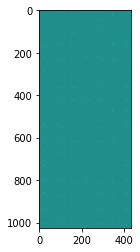

144.75938 0.0


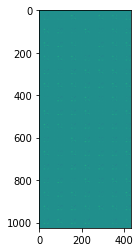

144.75938 0.0


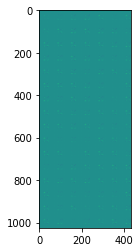

144.75938 0.0


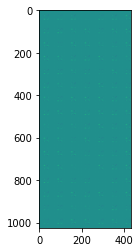

144.75938 0.0


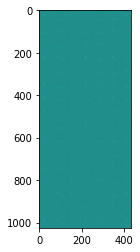

In [ ]:
from PIL import Image
from IPython.display import Audio


# generate ten random images
generator.eval()

generated_arrays = generator(torch.randn(5, 1, 18, 9).to('cuda')).detach().cpu().numpy()

i = 0
for curr_array in generated_arrays:
    curr_array = ((curr_array + 1)/2) * max_value
    print(curr_array.max(), curr_array.min())
    np.save("/content/drive/MyDrive/AI ML Projects/Music" + "/pytorch_CNN_5_epoch_" + str(i) + ".npy", curr_array)  
    i = i + 1
    plt.imshow(curr_array.reshape(1025, 431))
    plt.show()
    #Audio(reverse_log_ftf(curr_array) , rate=fs)

In [21]:
from IPython.display import Audio
output = np.load("/content/drive/MyDrive/AI ML Projects/Music" + "/pytorch_CNN_" + str(39) + ".npy")
print(output.max(), output.min(), output.reshape(1025,431).shape)
data_slice = reverse_log_ftf(output.reshape(1025,431))
print(output.max(), output.min(), data_slice.max(), data_slice.min())
Audio( data_slice, rate=fs)

144.75938 0.0 (1025, 431)
144.75938 0.0 532778.75 -495278.1


In [ ]:
temp_dir = "/content/drive/MyDrive/AI ML Projects/Music"
all_files = os.listdir("/content/drive/MyDrive/AI ML Projects/Music")

files_audio = [x for x in all_files if x.startswith('pytorch_basic_')]
for filename in files_audio:
  curr_image = Image.open(os.path.join(temp_dir, filename))
  curr_array = np.asarray(curr_image)
  print(curr_array.shape, curr_array.max(), curr_array.min(), curr_array.mean())

(1025, 431) 0 0 0.0
(1025, 431) 0 0 0.0
(1025, 431) 0 0 0.0
(1025, 431) 0 0 0.0
(1025, 431) 0 0 0.0
(1025, 431) 255 0 0.003298058966668553
(1025, 431) 255 0 17.080602116462
(1025, 431) 255 0 0.004380057721690906
(1025, 431) 0 0 0.0
(1025, 431) 0 0 0.0


In [ ]:
scale = data_slice
print("scale: ", scale.shape,  scale.min(), scale.max())
FRAME_SIZE = 2048
HOP_SIZE = 512    
S_scale = librosa.stft(scale.astype(np.float), n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
print("S_scale: ", S_scale.shape,  S_scale.min(), S_scale.max())
#y_hat = librosa.istft(S_scale, hop_length=HOP_SIZE)
#print(y_hat.shape,  y_hat.min(), y_hat.max())
#print(S_scale.shape, type(S_scale[0][0]))
Y_scale = S_scale ** 2
print("Y_scale: ", Y_scale.shape,  Y_scale.min(), Y_scale.max())
Y_log_scale = librosa.power_to_db(Y_scale)
print("Y_log_scale: ", Y_log_scale.shape,  Y_log_scale.min(), Y_log_scale.max())
Y_scale_reversed = librosa.db_to_power(Y_log_scale)
print("Y_scale_reversed: ", Y_scale_reversed.shape,  Y_scale_reversed.min(), Y_scale_reversed.max())
S_scale_reversed = np.sqrt(Y_scale_reversed)
print("S_scale_reversed: ", S_scale_reversed.shape,  S_scale_reversed.min(), S_scale_reversed.max())
scale_reversed = librosa.istft(S_scale_reversed, hop_length=HOP_SIZE)
print("scale_reversed: ", scale_reversed.shape,  scale_reversed.min(), scale_reversed.max())

NameError: ignored

In [ ]:
def save_audio(epoch):
  noise = np.random.normal(0,1,(1, latent_dim))
  gen_music = generator.predict(noise)
  gen_music = gen_music * data.max()
  fileName = "/content/drive/MyDrive/AI ML Projects/Music/" + str(epoch) + ".wav"
  print(gen_music[0].shape, gen_music.max(), gen_music.min(), fileName)
  wavfile.write(fileName, fs, gen_music[0])

def print_curr_spect(epoch):
  noise = np.random.normal(0,1,(1, latent_dim))
  gen_music = generator.predict(noise)
  gen_music =  (gen_music + 1.0) * (max_data_value / 2) 
  #gen_music = gen_music * data.max()
  #fileName = "/content/drive/MyDrive/AI ML Projects/Music/" + str(epoch) + ".wav"
  #print(gen_music[0].shape, gen_music.max(), gen_music.min(), fileName)
  #wavfile.write(fileName, fs, gen_music[0])
  print("epoch: ", epoch, gen_music[0].shape, gen_music.max(), gen_music.min())
  plot_spectrogram_from_log_array_sr(gen_music[0].astype(np.float), fs)


In [ ]:
from IPython.display import Audio
fileName = "26000.wav"
Audio("/content/drive/MyDrive/AI ML Projects/Music/" + fileName)

In [ ]:
fileName = "28000.wav"
fs_temp, data_temp = wavfile.read("/content/drive/MyDrive/AI ML Projects/Music/" + fileName)            # reading the file
#data_temp = data_temp *  data.max()
data_temp.shape

(220500,)

In [ ]:
rand_index = np.random.randint(0, 1000)
data_slice = data[:, 0][rand_index * latent_dim :(rand_index + 1) * latent_dim]
rand_index, data_slice.shape, type(data_slice)

(147, (220500,), numpy.ndarray)

In [ ]:
FRAME_SIZE = 2048
HOP_SIZE = 512    
rand_index_temp = np.random.randint(0, 1000, 10)
for rand_index in rand_index_temp:
  data_slice_temp = data[:, 0][rand_index * latent_dim :(rand_index + 1) * latent_dim]
  S_scale = librosa.stft(data_slice_temp.astype(np.float), n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
  Y_scale = S_scale ** 2
  Y_log_scale = librosa.power_to_db(Y_scale)
  print("Y_log_scale: ", Y_log_scale.shape,  Y_log_scale.min(), Y_log_scale.max(), Y_log_scale.mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


Y_log_scale:  (1025, 431) 54.316831807581195 134.3168318075812 64.34616772118399
Y_log_scale:  (1025, 431) 55.35988512684321 135.3598851268432 65.30490844521427
Y_log_scale:  (1025, 431) 56.80146907385031 136.8014690738503 69.32407806896578
Y_log_scale:  (1025, 431) 53.55710684629511 133.5571068462951 65.58417497945491
Y_log_scale:  (1025, 431) 57.191257935368725 137.19125793536872 70.43353603625559
Y_log_scale:  (1025, 431) 56.83702367242299 136.837023672423 68.33881973042112
Y_log_scale:  (1025, 431) 52.03291792013249 132.0329179201325 69.47529369858266
Y_log_scale:  (1025, 431) 47.806839369770216 127.80683936977022 53.56091947994421
Y_log_scale:  (1025, 431) 56.02425239430471 136.0242523943047 66.30492003986657
Y_log_scale:  (1025, 431) 54.438807236785294 134.4388072367853 60.73724021596234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


(1025, 431) 136.4408059204221 56.44080592042209


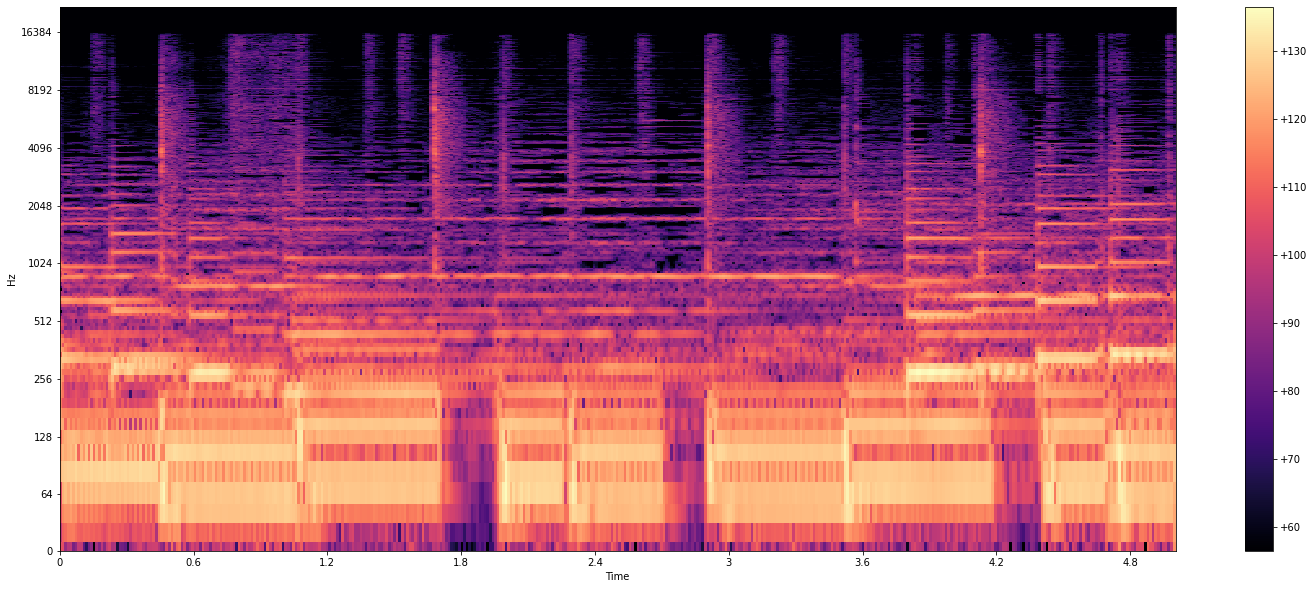

In [ ]:
plot_spectrogram_from_array_sr(data_slice.astype(np.float), fs, FRAME_SIZE = 2048, HOP_SIZE = 512)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


(1025, 431) (322757382714.6593-92150012114.7834j) (-398210318097.69336-279767970469.36505j)


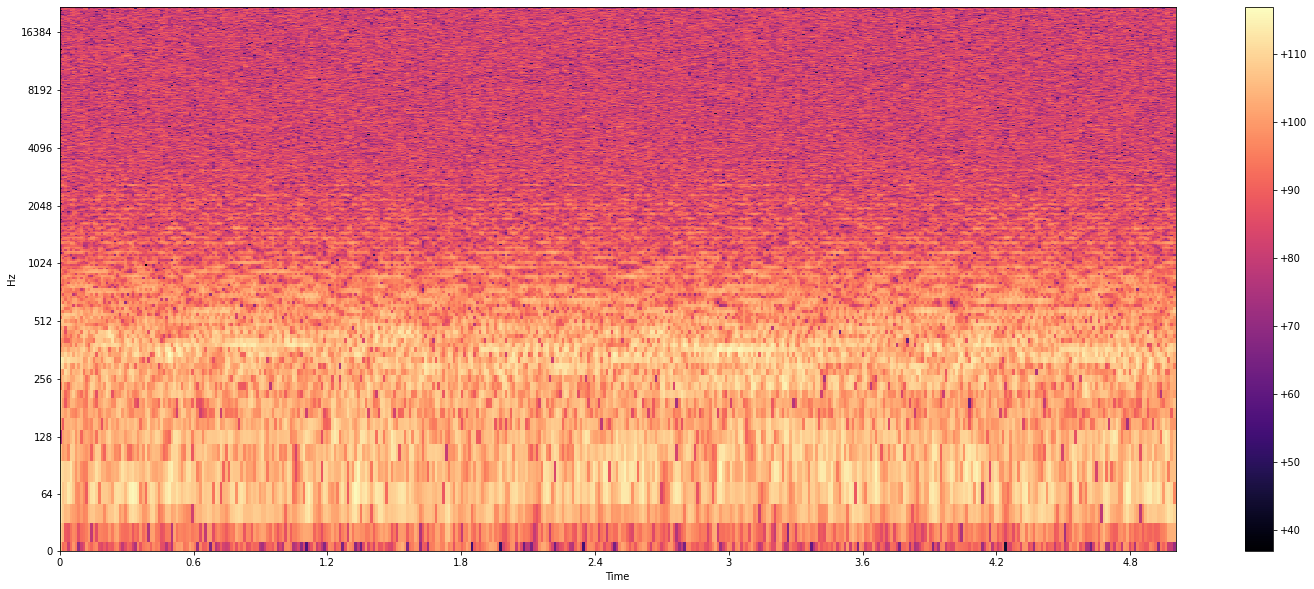

In [ ]:
plot_spectrogram_from_array_sr(data_temp.astype(np.float), fs_temp)

In [ ]:
from IPython.display import Audio
Audio(data_slice /data_slice.max() , rate=fs)

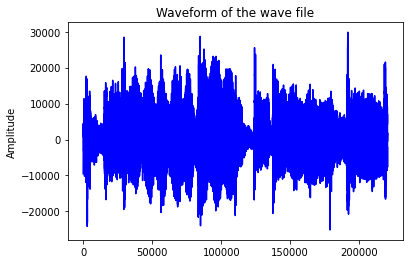

In [ ]:
plt.title('Waveform of the wave file')
plt.plot(data_slice, color = 'blue')
plt.ylabel('Amplitude')
plt.show()